# Lesson 1: Machine learning fundamentals

*Teachers:* Fares Schulz, Lina Campanella

In this course we will cover 
1. A recap on the concept of machine learning
2. Creating our own dataset
3. A detailed implementation of simple linear regression
4. A detailed implementation of simple binary classification
5. An explanation on Train–Test Split and Model Evaluation
6. Two exercises to explore polynomial regression and Normal Equations for linear regression

This script was inspired by the Creative Machine Learning course of Philippe Esling



# Defining Machine Learning

Machine learning aims to approximate an unknown mapping between input and output spaces, $\mathcal{X} \mapsto \mathcal{Y}$,
given only a finite set of Data
$
\mathcal{D} = \{(x_i, y_i)\}_{i=1}^{N},
$
where $(x_i \in \mathcal{X})$ and $(y_i \in \mathcal{Y})$.

We define a **parametric model**
$ f_{\boldsymbol{\theta}} \in \mathcal{F}$,
with parameters $(\boldsymbol{\theta} \in \boldsymbol{\Theta})$, chosen such that
$
f_{\boldsymbol{\theta}}(x) \approx y$.


Any machine learning problem involves these core components:
1. **Dataset** $(\mathcal{D})$: A collection of input-output pairs $ \mathcal{D} = \{(x_i, y_i)\}_{i=1} $, The dataset must be representative of the true underlying function $(f^*: \mathcal{X} \mapsto \mathcal{Y})$  
2. **Function or Model** $(f_{\boldsymbol{\theta}})$: A parameterized function that maps inputs $\mathbf{x}_i$ to predicted outputs $\mathbf{\hat{y}}_i = f_{{\theta}}(\mathbf{x_i})$ The choice of function defines the function space $\mathcal{F}_{\Theta}$
3. **Parameters ($\theta$)**: The set of parameters that define the specific function within the function space. These parameters are adjusted during training to minimize the empirical risk. come from the parameter space $\boldsymbol{\Theta}$
4. **Lossfunction**: A function that quantifies the difference between the predicted outputs $\mathbf{\hat{y}}_i$ and the true labels $\mathbf{y}_i$. The choice of loss function depends on the task (e.g., regression vs. classification).
5. **Optimization Algorithm**: A method for adjusting the parameters $\boldsymbol{\theta}$ to minimize the empirical risk $\hat{R}(\theta)$



## Linear Regression

To understand how a machine learning model works mathematically, we start with the case of simple linear regression, where $\mathbf{x}\in\mathbb{R}$. This implies that our model will follow
$$f_{\theta}(x) = \theta_0 + \theta_1 x$$

We will measure the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}(\theta) = \frac{1}{N}\sum_{i=1}^{N} ( y_{i} - f_{\theta}(x_i))^{2} = \frac{1}{N} \sum_{i=1}^{N}  ( y_{i} - (\theta_{0} + \theta_{1} x_{i}) )^{2}$$

Then our goal is to find the most adequate set of parameters $\theta = \{\theta_{0}, \theta_{1}\}$, which are those that minimize the MSE loss defined previously. To do so, we will implement the gradient descent algorithm.

### Manual implementation in NumPy

We start by performing a full manual implementation, in the sense that we need to manually derive the gradient in order to apply the gradient descent updates. To do so, we will rely on Numpy.

We start by importing libraries and set a random seed to ensure that the random number generator produces always a reproducible series of random numbers.

**Used functions**
- `np.random.seed`: sets the seed for the NumPy random number generator. [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

np.random.seed(42)

### Generate a synthetic dataset.

For the sake of this exercise, we will generate the data ourselves, so that we know the true values that we are looking for in advance. As in most real-world cases, our measurements are not perfect, they contain some amount of observation noise $\epsilon$ . Hence, we define a linear relationship following
$$y_i = f^*(\mathbf{x}_i) + \epsilon_i$$

**Useful functions**
- `np.random.rand`: generates an array of random numbers uniformly distributed over [0, 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html)
- `np.random.randn`: generates an array of random numbers from the standard normal distribution (mean 0, variance 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
- `np.random.uniform`" draws samples from a uniform distribution. [Documentation](https://numpy.org/doc/2.1/reference/random/generated/numpy.random.uniform.html)

Below, we will visualize synthetic data with generated noise levels.

In [2]:
# Setting the parameters
true_theta_0 = 4
true_theta_1 = -3
n_obs = 100

epsilon = np.random.randn(n_obs) * 0.3

In [ ]:
# Generating the data set
def generate_data(true_theta_0, true_theta_1, eps=0.7, n_obs=100):
    x = np.linspace(0, 1, n_obs) 
    y =  true_theta_1 * x + true_theta_0 +  eps * epsilon
    return x, y

# Plotting the data and the true function
def plot_data(eps=0.7):
    x, y = generate_data(true_theta_0, true_theta_1, eps, n_obs)
    plt.figure(figsize=(7,4))
    plt.scatter(x, y, color="C0", label="Created data")
    plt.plot(x, (true_theta_1*x + true_theta_0), color="C1", label="True function" )
    plt.title(rf"$y = {true_theta_1:.2f}*x + {true_theta_0:.2f} + ϵ, ϵ \in[-{eps:.2f},{eps:.2f}]$")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(0, 1)  
    plt.ylim(0, 5)
    plt.grid(True)
    plt.axhline(0, color='black', lw=1.5) 
    plt.axvline(0, color='black', lw=1.5)
    plt.legend()
    plt.show()

# Plot with interactive slider for epsilon
interact(
    plot_data,
    eps=widgets.FloatSlider(value=0.3, min=0.0, max=2, step=0.05, description="ϵ range"),
)


interactive(children=(FloatSlider(value=0.3, description='ϵ range', max=2.0, step=0.05), Output()), _dom_class…

<function __main__.plot_data(eps=0.7)>

In [4]:
# Data set for the linear regression with set epsilon
true_theta_0 = 2
true_theta_1 = 3
n_obs = 100
epsilon = np.random.randn(n_obs) * 0.2

x = np.linspace(0, 1, n_obs)
y = (true_theta_1 * x + true_theta_0) + epsilon

### Computing the MSE loss

The next step is to calculate the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}\left( \hat{\mathbf{y}},\theta \right) = \sum_{i=1}^{n} ( y_{i} - \hat{y}_{i} )^{2} = \sum_{i=1}^{n} ( y_{i} - ( \theta_{1} x_{i} + \theta_{0}) )^{2}$$

This will allow us to evaluate the performances of our model, but is also the basis for the gradient descent algorithm.


### Implement the gradient descent algorithm.

First we have to Iinitialize the parameters $\theta_1$ and $\theta_0$ to small random values
1. Evaluate the predictions made by our model 
$$\hat{y} = \theta_{1}x + \theta_0$$
2. Compute the mean squared error (MSE) loss between the predicted values and the ground truth labels: 
$$\mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y_i} )^2$$
3. Compute the gradients of the loss with respect to the parameters: 
$$\frac{\partial \mathcal{L}}{\partial \theta_1} = -\frac{2}{N} \sum_{i} (y_{i} - \hat{y}_{i})*x_{i}$$
$$\frac{\partial \mathcal{L}}{\partial \theta_0} = -\frac{2}{N} \sum_{i} (y_{i} -\hat{y}_{i})$$
4. Update the parameters using the gradients and a learning rate $\eta$: 
$$\theta_1 \leftarrow \theta_1 - \eta \frac{\partial \mathcal{L}}{\partial \theta_1}$$

$$\theta_0 \leftarrow \theta_0 - \eta \frac{\partial \mathcal{L}}{\partial \theta_0}$$

In [5]:
# Mean Squared Error loss function
def mse_loss_np(y, y_pred):
    return np.mean((y - y_pred)** 2)

def model_np(x, theta_0, theta_1):
    return theta_1 * x + theta_0

# Manually calculated gradients of the MSE loss function
def np_grad_loss_function(y,y_pred, x):
    dL_dtheta_1 = - 2 * np.mean((y - y_pred) * x)
    dL_dtheta_0 = - 2 * np.mean((y - y_pred ))
    return dL_dtheta_0, dL_dtheta_1

# Optimization with gradient descent
def gradient_descent_np(x, y, lr, n_iter):
    #  Initializing the parameters
    theta_1 = np.random.randn()
    theta_0 = np.random.randn()

    loss_history = []

    # Gradient Descent Loop 
    for i in range(n_iter):
        # Predictions
        y_pred = model_np(x, theta_0, theta_1)
        
        # Compute gradients
        dL_dtheta_0, dL_dtheta_1 = np_grad_loss_function(y,y_pred,x)

        # Update parameters
        theta_1 = theta_1 - lr * dL_dtheta_1
        theta_0 = theta_0 - lr * dL_dtheta_0

        # Compute Mean Squared Error loss
        loss_history.append(mse_loss_np(y, y_pred))

    return theta_0, theta_1, loss_history

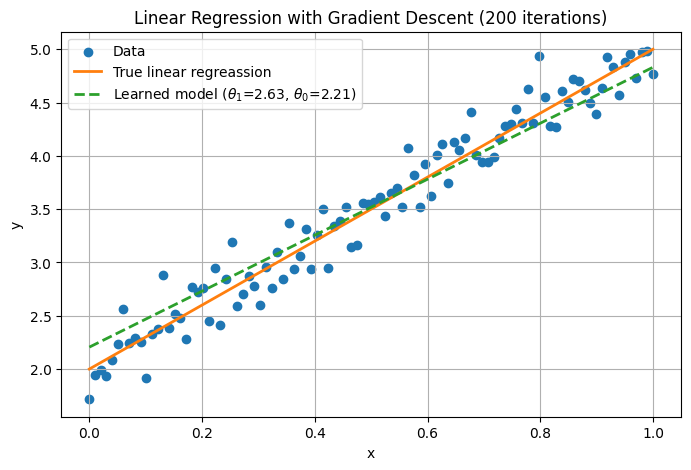

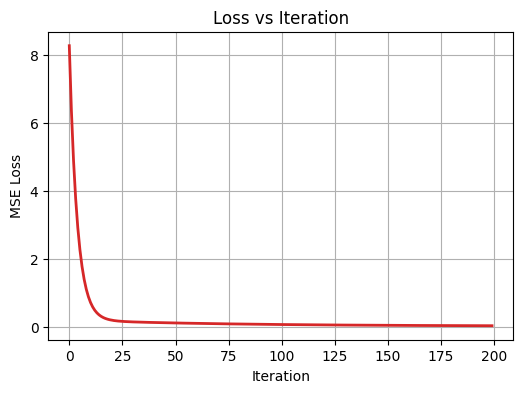

In [6]:
# Defining the number of iterations and learning rate
n_iters = 200
lr = 0.05

theta_0, theta_1, loss_history = gradient_descent_np(x, y, lr, n_iters)

# Plot data and fitted line
plt.figure(figsize=(8,5))
plt.scatter(x, y, color="C0", label="Data")
plt.plot(x, true_theta_1 * x + true_theta_0, color="C1", lw=2, label="True linear regreassion")
plt.plot(x, theta_1 * x + theta_0, color="C2", lw=2, linestyle="--", label=rf"Learned model ($\theta_1$={theta_1:.2f}, $\theta_0$={theta_0:.2f})")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Linear Regression with Gradient Descent ({n_iters} iterations)")
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Loss vs Iteration")
plt.grid(True)
plt.show()


### Implementation with Jax

The previous implementation required us to perform manual differentiation of our loss function to understand how to update the parameters. However, large developments have been made in the field of automatic differentiation. 

The recent library [JAX](https://github.com/google/jax) extends NumPy with this automatic differentiation feature, while providing a functional approach to numerical computing, allowing for easy gradient computation. Its ability to handle complex and custom gradients makes JAX particularly well-suited for advanced research projects. Similar to NumPy, we strongly encourage you to learn JAX through the set of [tutorials](https://jax.readthedocs.io/en/latest/).

Note that `JAX` has been thought as an extension of `NumPy`, therefore an extremely large portion of its API simply mirrors the `NumPy` functions by adding automatic differentiation features to it.

**Useful functions**
- `random.PRNGKey`: function to generate a key for the pseudorandom number generator. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html)
- `jit`: function to compile a function for faster execution [Documentation](https://jax.readthedocs.io/en/latest/jit.html)
- `grad`: function to compute the gradient of a function [Documentation](https://docs.jax.dev/en/latest/_autosummary/jax.grad.html#jax.grad)

In [7]:
import jax.numpy as jnp
from jax import grad, random

key = random.PRNGKey(42)

### Dataset

We can simply keep our previous approach to generating the dataset but we will rely on `jnp.ndarray` instead of `np.ndarray`. 

**Useful functions**
- `random.split`: function to split a PRNGKey into a list of subkeys [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html)
- `random.uniform`: function to generate an array of uniformly distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html)
- `random.normal`: function to generate an array of normally distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html)

In [8]:
# Splits the key and uses the keys to create data points
key_0, key_1, key = random.split(key, 3)
x = random.uniform(key_0, (n_obs,))
epsilon = random.normal(key_1, (n_obs,)) * 0.2
y = true_theta_0 + true_theta_1 * x + epsilon

### Loss function

Similarly we have to define the loss function and its gradient.

**Useful function**
- `jnp.mean`: function to compute the mean of an array [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.mean.html)

In [11]:
# Mean Squared Error loss function
def mse_loss_jax(y, y_pred):
    return jnp.mean((y - y_pred)**2)

def model_jax(x, theta_0, theta_1):
    return theta_1 * x + theta_0

# Combined loss function that takes parameters directly
# This is needed for jax's grad function
def loss_with_params_jax(theta_0, theta_1, x, y):
    y_pred = model_jax(x, theta_0, theta_1)
    return mse_loss_jax(y, y_pred)

# Optimization with gradient descent using jax's grad function 
def gradient_descent_jax(key, x, y, lr, n_iter):
    # Initializing the parameters
    k_0, k_1 = random.split(key, 2)
    theta_0 = random.normal(k_0, (1,))
    theta_1 = random.normal(k_1, (1,))
    loss_history = []

    # Compute gradients with respect to theta_0 (arg 0) and theta_1 (arg 1)
    grad_loss_function = grad(loss_with_params_jax, argnums=[0, 1])


    for i in range(n_iter):
        # Compute gradients with respect to parameters
        dL_dtheta = grad_loss_function(theta_0, theta_1, x, y)
        
        # Update the parameters
        theta_0 -= lr * dL_dtheta[0]
        theta_1 -= lr * dL_dtheta[1]

        # Compute predictions and loss for monitoring
        y_pred = model_jax(x, theta_0, theta_1)
        loss_history.append(mse_loss_jax(y, y_pred))

    return theta_0, theta_1, loss_history



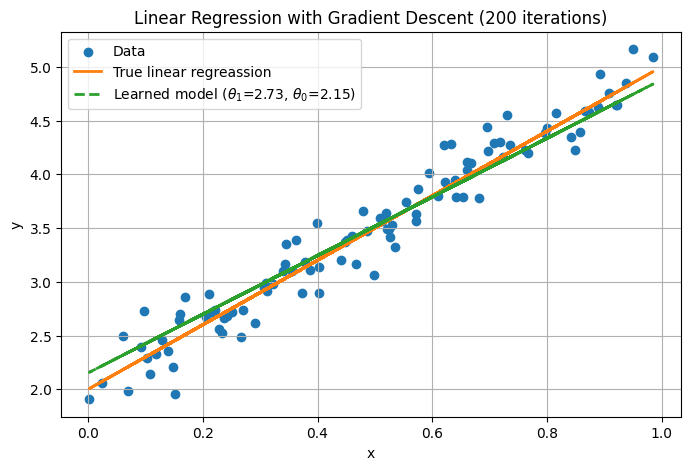

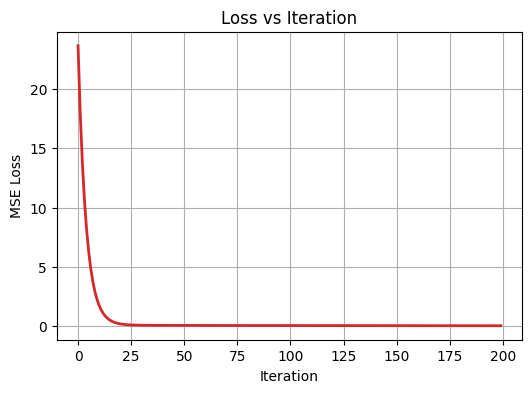

In [12]:
# Defining the number of iterations and learning rate
n_iter = 200
lr = 0.05

theta_0, theta_1, loss_history = gradient_descent_jax(key,x, y, lr, n_iters)

# Plot data and fitted line
plt.figure(figsize=(8,5))
plt.scatter(x, y, color="C0", label="Data")
plt.plot(x, (true_theta_1 * x + true_theta_0), color="C1", lw=2, label="True linear regreassion")
plt.plot(x, theta_1 * x + theta_0, color="C2", lw=2, linestyle="--", label=rf"Learned model ($\theta_1$={theta_1[0]:.2f}, $\theta_0$={theta_0[0]:.2f})")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Linear Regression with Gradient Descent ({n_iters} iterations)")
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Loss vs Iteration")
plt.grid(True)
plt.show()


## Binary Classification

In binary classification, the goal is to assign each input $ \mathbf{x} $ in $ \mathbb{R}^d $ to one of two possible classes, typically represented as $ y \in \{-1, +1\} $.

For this exercise we will use a linear classifier model. The relationship between inputs and outputs use a linear decision function:

$$
f(\mathbf{x}) = \theta_0 + \theta_1 x_1 + \theta_2 x_2
$$

The predicted label is obtained from the sign of this function:

$$
\hat{y} = \text{sign}(f_{\theta}(\mathbf{x}))
$$

The parameters $ \boldsymbol{\theta} = (\theta_0, \theta_1, \theta_2) $ are estimated by minimizing the Hinge loss function that penalizes incorrect or uncertain predictions.  





In [17]:
# Creating a new data set
n_obs = 100
epsilon = np.random.randn(n_obs) * 2

# Input
x_class_0_0 = np.linspace(0, 1.1, n_obs)
x_class_1_0 = np.linspace(0.5, 2, n_obs)

# Output 
x_class_0_1 = -3 * x_class_0_0**3 + 13 + epsilon
x_class_1_1 = 2 * x_class_1_0**3 + 2 + epsilon

X = np.vstack([
    np.stack([x_class_0_0, x_class_0_1], axis=1),
    np.stack([x_class_1_0, x_class_1_1], axis=1)
])
Y = np.concatenate([
    -np.ones_like(x_class_0_0),
    np.ones_like(x_class_1_0)
])


### Hinge Loss

The Hinge Loss function is Loss function that is commonly used in binary classification models. 



For a single data point $(x_i, y_i)$, where $ y_i \in \{-1, +1\} $, the hinge loss is defined as:

$$
\mathcal{L_{hinge}} = \frac{1}{N} \sum{i}^N \max(0, 1 - y_i f_{\theta}(x_i))
$$

- If the prediction $f(x_i)$ has the same sign as $ y_i $ and its magnitude is ≥ 1, then the loss is 0: the point is correctly classified and outside the margin.  
- If the prediction is incorrect or within the margin, the loss increases linearly as $f(x_i)$ moves away from the correct side.


This time we will use Stochastic Gradient Descent (SGD) as the optimazation algorithm. With SGD parameters are updated using gradient from a single randomly selected sample per iteration.

### Gradient Descent vs. Stochastic Gradient Descent (SGD)

Both gradient descent and stochastic gradient descent (SGD) are optimization algorithms used to minimize a loss function by iteratively updating model parameters in the direction of the negative gradient.

**Gradient Descent**
- Uses all training samples to compute the gradient at each iteration.  
- Provides a precise estimate of the true gradient.  
- Updates are smooth and stable, but computation can be expensive for large datasets.  
- The parameter update rule is:

  $$
  \boldsymbol{\theta_{t+1}} = \boldsymbol{\theta_t} - \eta \nabla_\theta \hat{R}(\boldsymbol{\theta_t}) = \boldsymbol{\theta_t} - \frac{\eta}{N} \displaystyle\sum_{i=1}^N \nabla_\theta \ell(f_{\theta_t}(x_{i_t}) , y_{i_t})
  $$

  where $ \eta $ is the learning rate and $ \ell$ is a single sample loss function.

**Stochastic Gradient Descent (SGD)**
- Uses one randomly chosen training sample per iteration to approximate the gradient.  
- Each update is fast, but the gradient estimate is noisy.  
- The loss fluctuates more during training but still tends to decrease on average.  
- This noise can help escape shallow local minima and improve generalization.

The update rule becomes:

  $$
  \theta_{t+1} = \theta_t - \eta \nabla_\theta \ell(f_{\theta_t}(x_{i_t}) , y_{i_t})
  $$



<!-- #### Summary

| Method | Gradient Computation | Stability  Computation per Step | Typical Use |
|---------|----------------------|------------|----------------------|--------------|
| Gradient Descent | Full dataset | Smooth, stable | High | Small datasets |
| Stochastic Gradient Descent | One sample | Noisy, oscillatory | Very low | Large datasets |

In practice, many modern algorithms use a compromise called **mini-batch SGD**, which computes the gradient on a small random subset of the data to balance efficiency and stability. -->


### Numpy implementation

In [25]:
# Hinge loss function
def hinge_loss_np(y, y_pred):
    losses = 1 - y * y_pred
    losses = np.maximum(0, losses)
    return np.mean(losses)

# Manually calculated gradients of the Hinge loss function 
def hinge_gradient_np(x_i, y_i, theta_0, theta_1, theta_2):
    f_i = theta_0 + theta_1 * x_i[0] + theta_2 * x_i[1]
    if 1 - y_i * f_i > 0:  # only if violating margin
        dtheta_0 = -y_i
        dtheta_1 = -y_i * x_i[0]
        dtheta_2 = -y_i * x_i[1]
    else:
        dtheta_0 = dtheta_1 = dtheta_2 = 0.0
    return dtheta_0, dtheta_1, dtheta_2

# Optimization with stochastic gradient descent using numpy 
def stochastic_gradient_descent_np(x, y, lr=0.05, n_iter=1000):
    theta_0 = np.random.randn()
    theta_1 = np.random.randn()
    theta_2 = np.random.randn()

    loss_history = []

    for i in range(n_iters):
        i_t = np.random.randint(len(x))
        x_i = x[i_t]
        y_i = y[i_t]

        
        # Compute loss (for monitoring)
        y_pred_full = theta_0 + theta_1 * x[:,0] + theta_2 * x[:,1]
        loss_history.append(hinge_loss_np(y, y_pred_full))


        # Gradients
        dL_dtheta_0, dL_dtheta_1, dL_dtheta_2 = hinge_gradient_np(x_i, y_i, theta_0, theta_1, theta_2)

        # Update parameters
        theta_0 -= lr * dL_dtheta_0
        theta_1 -= lr * dL_dtheta_1
        theta_2 -= lr * dL_dtheta_2
        theta = [theta_0,theta_1,theta_2]

    return theta, loss_history



In [ ]:
# Defining the number of iterations and learning rate
n_iters = 5000
lr = 0.003

theta, loss_history = stochastic_gradient_descent_np(X, Y, lr, n_iters)

theta_0, theta_1, theta_2 = theta

x_line = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_line = -(theta_0 + theta_1 * x_line ) / theta_2

# Plot data and fitted line
plt.figure(figsize=(8,5))
plt.scatter(x0, y0, color="C0", label="Class 0")
plt.scatter(x1, y1, color="C1", label="Class 1")
plt.plot(x_line, y_line, color="black", lw=2, label=rf"sign boundary ($\theta_0 = {round(theta_0,2)}$, $\theta_1 = ${round(theta_1,2)}, $\theta_2 = ${round(theta_2,2)})")
plt.xlabel("x")
plt.ylabel("y")
plt.title(rf"Binary classification with Gradient Descent ({n_iters} iterations)")
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Loss vs Iteration")
plt.grid(True)
plt.show()


### Jax Implementation

We will repeat the same exercize using the JAX library to get a better understanding of JAX.

In [14]:
key = random.PRNGKey(42)
epsilon = random.normal(key, (n_obs,)) * 2

In [18]:
# Hinge loss function  
def hinge_loss_jax(theta, x, y):
    theta_0, theta_1, theta_2 = theta
    f = theta_0 + theta_1 * x[:, 0] + theta_2 * x[:, 1]
    losses = 1 - y * f
    losses = jnp.maximum(0, losses)
    return jnp.mean(losses)

# Compute gradient for one-sample loss
def single_loss_jax(theta, x_i, y_i):
    f_i = theta[0] + theta[1] * x_i[0] + theta[2] * x_i[1]
    return jnp.maximum(0, 1 - y_i * f_i)

# Optimization with stochastic gradient descent using jax's grad
def stochastic_gradient_descent_jax(key, x, y, lr=0.05, n_iter=1000):
    theta = random.normal(key, (3,))  # [theta_0, theta_1, theta_2]
    
    loss_history = []
    for i in range(n_iters):
        # Sample one random observation
        key, subkey = random.split(key)
        i_t = random.randint(subkey, shape=(), minval=0, maxval=len(x))
        x_i = x[i_t]
        y_i = y[i_t]


        grads = grad(single_loss_jax)(theta, x_i, y_i)

        # Parameter update
        theta = theta - lr * grads

        # Compute full loss (for monitoring)
        loss_history.append(hinge_loss_jax(theta, x, y))

    return theta, loss_history
    

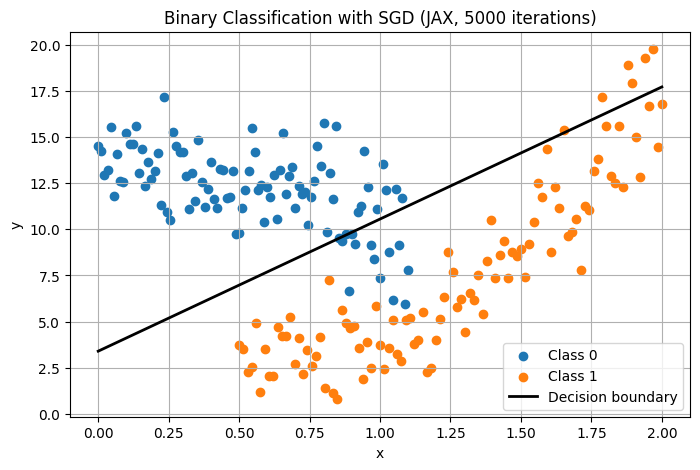

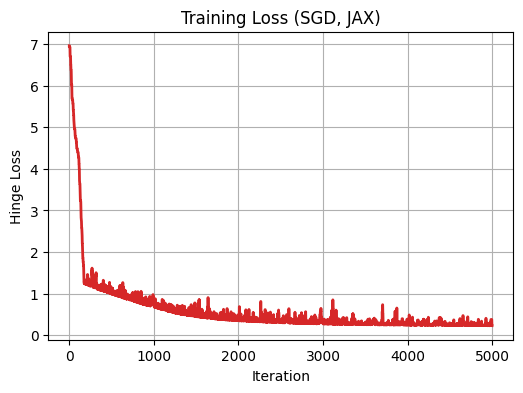

In [20]:
# Defining the number of iterations and learning rate
n_iters = 5000
lr = 0.003

theta, loss_history = stochastic_gradient_descent_jax(key, X, Y, lr, n_iters)

theta_0, theta_1, theta_2 = theta

x_line = jnp.linspace(X[:,0].min(), X[:,0].max(), 100)
y_line = -(theta_0 + theta_1 * x_line) / theta_2

# Plot data and fitted line
plt.figure(figsize=(8,5))
plt.scatter(x_class_0_0, x_class_0_1, color="C0", label="Class 0")
plt.scatter(x_class_1_0, x_class_1_1, color="C1", label="Class 1")
plt.plot(x_line, y_line, color="black", lw=2, label="Decision boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Binary Classification with SGD (JAX, {n_iters} iterations)")
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")
plt.title("Training Loss (SGD, JAX)")
plt.grid(True)
plt.show()

## Train–Valid-Test Split and Model Evaluation

To properly assess how well a machine learning model generalizes, we must evaluate it on data it has not seen during training.  
If we only measure performance on the training data, there is a risk of overfitting the model. Overfitting the model means using overly complex models (e.g., high-degree polynomials) can lead to fitting noise rather than the underlying pattern, resulting in poor generalization to new data.

A standard approach is to split the available dataset into three parts:
- **Training set:** used to fit the model parameters.
- **Validation set:** used for an unbiased evaluation of the model
- **Test set:** used for the final evaluation of the model. This data is only used at the very end.


Below, we’ll split our dataset from the first exercise on linear regression into two data sets, a training and a validation set, train the model on the training data, and compare the loss on both the training and validation sets.


In [22]:
# Splitting our dataset 80/20
train_size = int(0.8 * len(x))

x_train, x_valid = x[:train_size], x[train_size:]
y_train, y_valid = y[:train_size], y[train_size:]


In [23]:
n_iters = 200
lr = 0.03

theta_0, theta_1, loss_history = gradient_descent_jax(key, x_train, y_train, lr, n_iters)

print(rf"Gradient Descent coefficients: theta_0 = {round(theta_0,2)}, theta_1 = {theta_1}" )

Gradient Descent coefficients: theta_0 = [2.1299999], theta_1 = [2.7517393]


In [24]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

y_pred_train = theta_0 + theta_1 * x_train
y_pred_valid = theta_0 + theta_1 * x_valid 
mse_train = mean_squared_error(y_train, y_pred_train)
mse_valid = mean_squared_error(y_valid, y_pred_valid)

print("MSE for Gradient Descent for the training data:", mse_train)
print("MSE for Gradient Descent for the validation data:",  mse_valid)

MSE for Gradient Descent for the training data: 0.040729832
MSE for Gradient Descent for the validation data: 0.036479842


Since the model is fitted well we see that the MSE is almost the same for both the training set and the validation set. When we overfit this error will be bigger.

## Exercises

### Exercise 1 - Polynomial Regression

In this exercise, you will implement polynomial regression. You can choose to use NumPy or JAX.

In [ ]:
n_obs = 100
epsilon = np.random.randn(n_obs) * 2

x = np.linspace(0, 1, n_obs)
y = np.sin(2 * np.pi * x) + epsilon

In [ ]:
def model(x, thetas):
    """
    Compute polynomial predictions for input x.
    Inputs:
        x       : array of input values
        thetas  : array of parameters [θ₀, θ₁, ..., θ_d]
    Returns:
        y_pred  : array of predicted values
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    return y_pred


def mse_loss(y, y_pred):
    """
    Compute the Mean Squared Error (MSE) loss.
    Inputs:
        y       : array of true target values
        y_pred  : array of predicted target values
    Returns:
        loss    : float, mean squared error
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    return loss

def np_grad_loss_function(x, y, y_pred):
   """
    Compute the gradient of the loss function.
    Inputs:
        x       : array of input values
        y       : array of true target values
        y_pred  : array of predicted target values
    Returns:
        dL_dtheta  : array of gradients to update the parameters
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    return dL_dtheta

def gd_regression(x, y, n_iter, lr, degree, loss_func, seed=0):
    """
    Perform gradient descent for polynomial regression.
    Inputs:
        x          : array of observations
        y          : array of target values
        n_iter     : number of iterations
        lr         : learning rate
        degree     : polynomial degree
        loss_func  : function to compute loss (e.g. mse_loss)
        seed       : random seed
    Returns:
        thetas        : array of learned coefficients [θ₀, θ₁, ..., θ_d]
        loss_history  : list of loss values per iteration
    """
    # Random initialization

    ######################
    # YOUR CODE GOES HERE
    ######################

    for i in range(n_iter):
        ######################
        # YOUR CODE GOES HERE
        ######################
        pass

    return thetas, loss_history